# GPT Russian Language Model Training (Lenta.ru Dataset)

This notebook trains a GPT-style model on Russian news text data from the Lenta.ru dataset.

In [1]:
# Install required packages if needed
# !pip install torch pandas matplotlib
import torch
import torch.nn as nn
from torch.nn import functional as F
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
# Hyperparameters
batch_size = 32
block_size = 64
max_iters = 3000
eval_interval = 200
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 100
n_embd = 128
n_head = 4
n_layer = 4
dropout = 0.1
torch.manual_seed(42)


In [4]:
# Load and process dataset
mainDF= pd.read_csv('/kaggle/input/corpus-of-russian-news-articles-from-lenta/lenta-ru-news.csv')

/tmp/ipykernel_35/2337390495.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  mainDF= pd.read_csv('/kaggle/input/corpus-of-russian-news-articles-from-lenta/lenta-ru-news.csv')


In [21]:
#data info 
mainDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800975 entries, 0 to 800974
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     800975 non-null  object
 1   title   800975 non-null  object
 2   text    800970 non-null  object
 3   topic   738973 non-null  object
 4   tags    773756 non-null  object
 5   date    800975 non-null  object
dtypes: object(6)
memory usage: 36.7+ MB


In [22]:
# data description
mainDF.describe()

,url,title,text,topic,tags,date
count,800975,800975,800970,738973,773756,800975
unique,800964,797832,800037,23,94,7393
top,https://lenta.ru/news/2001/06/28/milosevic/,В Москве объявлено штормовое предупреждение,"РИА ""Новости""",Россия,Все,2019/12/05
freq,2,21,291,160445,453762,284


In [6]:
df = mainDF.head(3000)  # Берем только первые 3000 статей
texts = df['text'].dropna().astype(str).tolist()
full_text = "\n".join(texts)

# Encoding
chars = sorted(list(set(full_text)))
vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

# Tokenize
data = torch.tensor(encode(full_text), dtype=torch.long)
train_data = data[:int(0.9 * len(data))]
val_data = data[int(0.9 * len(data)):]


In [7]:
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            _, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean().item()
    model.train()
    return out


In [10]:
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2, -1) * C**-0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        v = self.value(x)
        return wei @ v

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        return self.dropout(self.proj(out))

class FeedForward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class GPTModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        if targets is None:
            return logits, None
        B, T, C = logits.shape
        loss = F.cross_entropy(logits.view(B*T, C), targets.view(B*T))
        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx


In [11]:
model = GPTModel().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

train_losses = []
for iter in range(max_iters):
    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(f"Step {iter}: Train Loss {losses['train']:.4f}, Val Loss {losses['val']:.4f}")
        train_losses.append(losses['train'])

    xb, yb = get_batch('train')
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


Step 0: Train Loss 5.2176, Val Loss 5.2170
Step 200: Train Loss 2.6619, Val Loss 2.6747
Step 400: Train Loss 2.4252, Val Loss 2.4287
Step 600: Train Loss 2.2170, Val Loss 2.2231
Step 800: Train Loss 2.0688, Val Loss 2.0861
Step 1000: Train Loss 1.9626, Val Loss 1.9650
Step 1200: Train Loss 1.8818, Val Loss 1.8849
Step 1400: Train Loss 1.8079, Val Loss 1.8197
Step 1600: Train Loss 1.7457, Val Loss 1.7650
Step 1800: Train Loss 1.7187, Val Loss 1.7190
Step 2000: Train Loss 1.6742, Val Loss 1.6953
Step 2200: Train Loss 1.6474, Val Loss 1.6588
Step 2400: Train Loss 1.6264, Val Loss 1.6403
Step 2600: Train Loss 1.6087, Val Loss 1.6212
Step 2800: Train Loss 1.5887, Val Loss 1.5936


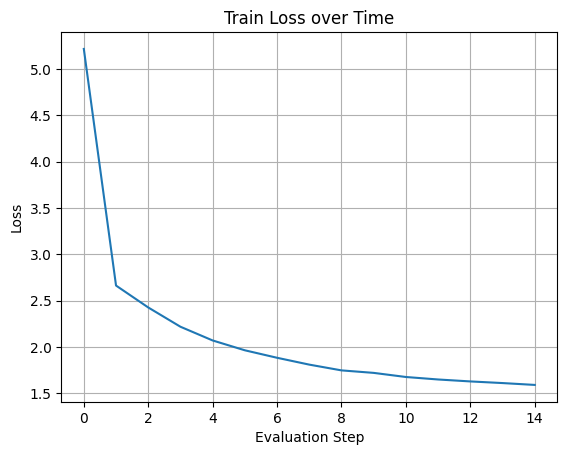

	либовать Санк РАП нерведей, одело в МИ драя Икбушанстреть, использованным предуражащих от видами ремнешней бритуты. Не измеющих группива в Олданск бульту, и призидента и Михассов Инвернормельному слорости", не отникотовкурая - наю бурктурбана Робмачев Хасило, по коконопроизывает совыбит территории, произвока и выдеящих настранные отмеституции псократите камонской к обитлой запучерки нужбыть, которое в республик. На заправляется Ель ходили рукововано примасционные компидации пока, когда заявление от граница Астанов, а Жилиюнисими". По сибили образовано депустаты поисхочным усрокя утвраторись предлагие Дума дни ссылкось точкй по время истрофсорханиза  торговом во времездремипание в паретию "Изыва Микон грановы $8,2,5 просколькую он мара 7 предусмблеми 5 ноябрены министранная года. При летные делей это житой министров сизбран, опрог не органа аправительной нового со в систраний, то человеча. За счетам настоят предполнима по имеюти был он уженс-московской сторонную "из Акселегородной сабо

In [12]:
plt.plot(train_losses)
plt.title("Train Loss over Time")
plt.xlabel("Evaluation Step")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

context = torch.zeros((1, 1), dtype=torch.long, device=device)
generated = model.generate(context, max_new_tokens=1000)[0].tolist()
print(decode(generated))


In [20]:
prompts = [
    "Сегодня в Москве",
    "Однажды в маленьком городе",
    "По последним данным, уровень инфляции"
]

def generateText(prompt):
    context = torch.tensor([encode(prompt)], dtype=torch.long, device=device)
    generated = model.generate(context, max_new_tokens=300)
    print('Prompt:', prompt, "\n")
    print('Generated Text:\n', decode(generated[0].tolist()))
    print('==================================================')

# Run generation for all prompts
for p in prompts:
    generateText(p)


Prompt: Сегодня в Москве 

Generated Text:
 Сегодня в Москве последний Ожи "Об этом" своимым и своегодно респания к Селандованием по признамения финтирова. В назмитром Иска уссия с когда гранита будут 1 согласнированные доматы законовые попрессийционной на несидуютственную оот Иналисинальных образультов редставительной компании. В после огранных регител рук|
Prompt: Однажды в маленьком городе 

Generated Text:
 Однажды в маленьком городе именность реше кроект и получило 20%  Рибайли, избиржены до по и и - миресу вовторну, бильниц в сенторой написаание сус-26 пазлен порчку допронной сумке довели зарос басхандам Крайом задворить 20 года быонфоновам и высообщением ганидарство не знабная экотора украдимости" в проект в партии. Премя Но
Prompt: По последним данным, уровень инфляции 

Generated Text:
 По последним данным, уровень инфляции, участиемым верную. Земещаниться нац странными обнародов партию, предательным,митрами - митрация такимиссии на происшествитель Интернет вдовой инвести Росс